# Galloway Math 7241 Markov Chain Project

In [1]:
import numpy as np
from scipy.linalg import eig 
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import pickle
import os
plt.style.use('ggplot')
np.set_printoptions(precision=4,suppress=True)
pd.set_option('precision', 4)


def findStationary(P):
    # given markov chain transition matrix, calculates
    # the stationary distribution
    S,U =eig(P.T,left=False, right=True) # get right eigenvectors and eigvals
    eigval_is_one = np.where(np.abs(S - 1.) < 1e-8)[0][0] # find the eigenval = 1
    sd = np.array(U[:, eigval_is_one].flat) # collect eigenvector of interest
    sd = sd / np.sum(sd) # normalize so the vector elements sum to 1


## Steps 1 and 2: Read in and Clean Data

In [2]:
'''Read in Data'''
path = 'data'
fileName = '2338810.csv'

dataPath = os.path.join(path,fileName)
TMatrixPath = os.path.join(path,'TMatrix.csv')
rawdf = pd.read_csv(dataPath)

In [3]:
rawdf.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,AWND_ATTRIBUTES,FMTM,FMTM_ATTRIBUTES,...,WT17,WT17_ATTRIBUTES,WT18,WT18_ATTRIBUTES,WT19,WT19_ATTRIBUTES,WT21,WT21_ATTRIBUTES,WT22,WT22_ATTRIBUTES
0,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,2000-01-01,11.41,",,X",1432.0,",,X",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,2000-01-02,8.95,",,X",2235.0,",,X",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,2000-01-03,12.97,",,X",2222.0,",,X",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,2000-01-04,14.32,",,X",1724.0,",,X",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,2000-01-05,16.11,",,X",1230.0,",,X",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Save off Weather Station and Name
station = rawdf.iloc[0,0]
location = rawdf.iloc[0,1]
print('Weather Station: ' + station)
print('Location: ' + location)

Weather Station: USW00014739
Location: BOSTON, MA US


In [5]:
'''Inspect data'''
display(rawdf.info())
print('NaN Values')
display(rawdf.isnull().sum().sort_values(ascending = False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7306 entries, 0 to 7305
Data columns (total 76 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STATION          7306 non-null   object 
 1   NAME             7306 non-null   object 
 2   LATITUDE         7306 non-null   float64
 3   LONGITUDE        7306 non-null   float64
 4   ELEVATION        7306 non-null   float64
 5   DATE             7306 non-null   object 
 6   AWND             7306 non-null   float64
 7   AWND_ATTRIBUTES  7306 non-null   object 
 8   FMTM             4313 non-null   float64
 9   FMTM_ATTRIBUTES  4313 non-null   object 
 10  PGTM             4194 non-null   float64
 11  PGTM_ATTRIBUTES  4194 non-null   object 
 12  PRCP             7304 non-null   float64
 13  PRCP_ATTRIBUTES  7304 non-null   object 
 14  SNOW             7306 non-null   float64
 15  SNOW_ATTRIBUTES  7306 non-null   object 
 16  SNWD             1718 non-null   float64
 17  SNWD_ATTRIBUTE

None

NaN Values


WT10               7305
WT10_ATTRIBUTES    7305
WT21_ATTRIBUTES    7304
WT21               7304
WT15               7298
                   ... 
TMIN_ATTRIBUTES       0
TMIN                  0
TMAX_ATTRIBUTES       0
SNOW                  0
STATION               0
Length: 76, dtype: int64

### Visualize Data

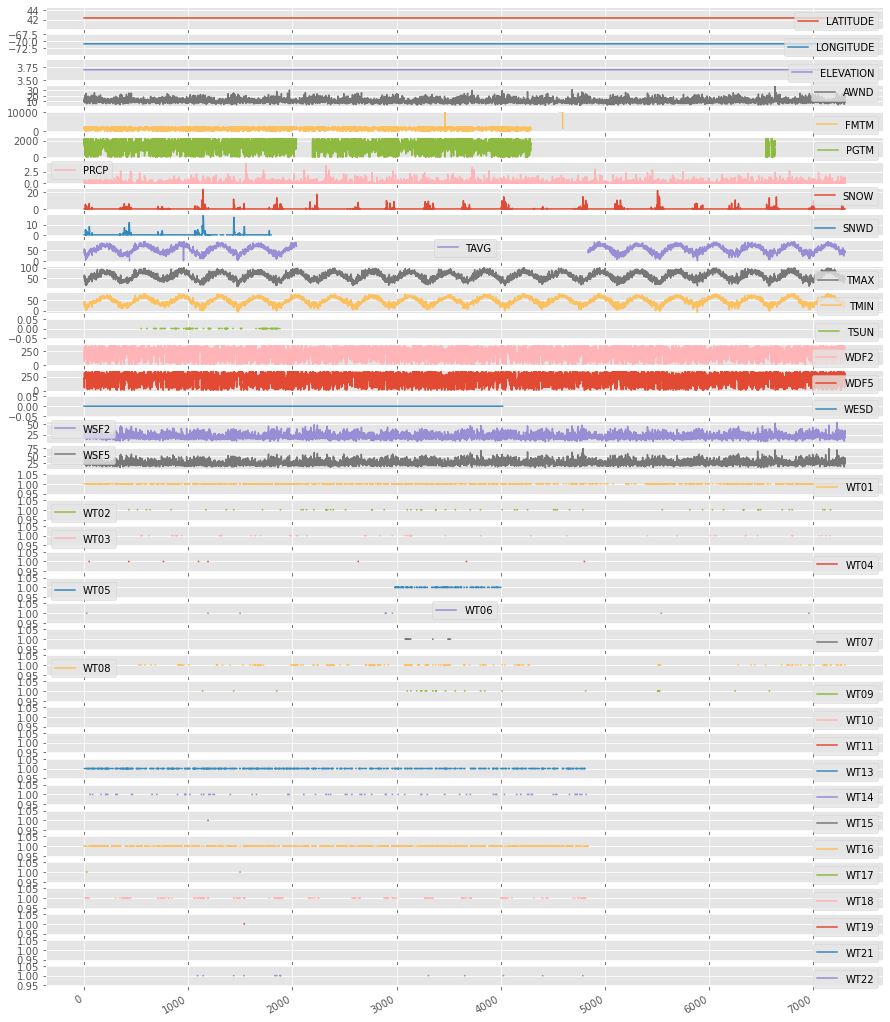

In [6]:
_ = rawdf.plot(figsize=(15,20),subplots=True)

### Seperate Out Average Wind Speed

In [7]:
# convert date column to datetime type (date time year-month-day hour:minute:second)
rawdf.DATE  = pd.to_datetime(rawdf.DATE, format='%Y-%m-%d')

# make date the index
rawdf.set_index('DATE',inplace=True)
df = rawdf.AWND
display(df.head())
display(df.tail())
display(df.describe())

DATE
2000-01-01    11.41
2000-01-02     8.95
2000-01-03    12.97
2000-01-04    14.32
2000-01-05    16.11
Name: AWND, dtype: float64

DATE
2019-12-28    10.96
2019-12-29     7.16
2019-12-30    20.80
2019-12-31    13.42
2020-01-01    15.43
Name: AWND, dtype: float64

count    7306.0000
mean       10.9357
std         3.7589
min         2.2400
25%         8.2800
50%        10.2900
75%        12.9700
max        38.0300
Name: AWND, dtype: float64

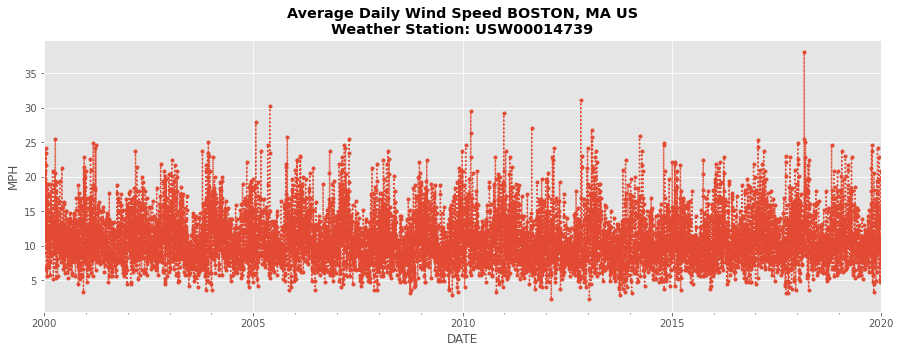

In [8]:
title = 'Average Daily Wind Speed {:s}\nWeather Station: {:s}'.format(location, station)
df.plot(figsize=(15,5),linestyle='dotted', marker='.')
plt.title(title,fontweight='bold')
_ = plt.ylabel('MPH')

In [9]:
'''Filter out Extremely High MPH Outliers'''
max_mph = 27
original_data_length = len(df)
df = df[df.values <= max_mph]
cleaned_data_length = len(df)
filtered_data = original_data_length - cleaned_data_length
print('Original Data Length: {:d}'.format(original_data_length))
print('Cleaned Data Length: {:d}'.format(cleaned_data_length))
print('Filtered Data Amount: {:d}'.format(filtered_data))

Original Data Length: 7306
Cleaned Data Length: 7299
Filtered Data Amount: 7


# Step 3: Map data to Markov Chain
### Step 4: Read in to CAS

### Analyze Windspeed Data

In [10]:
1 + 3.322 * np.log(filtered_data)

7.46431351516175

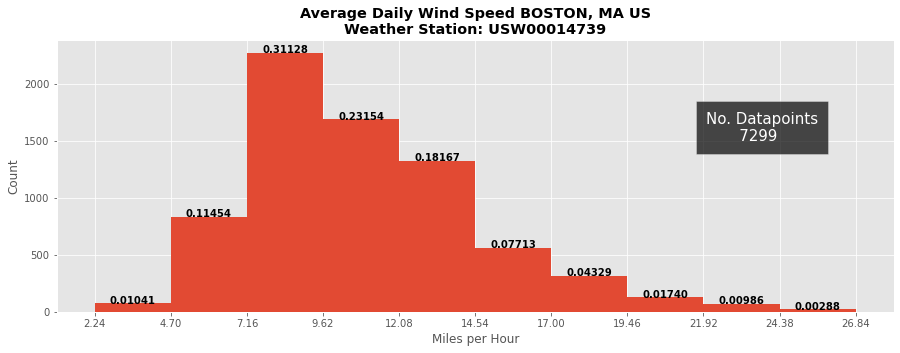

In [11]:
n_bins = 10

freqs, bins = np.histogram(df.values,bins=n_bins)
total_cnt = freqs.sum()
occ_freqs = freqs/total_cnt
fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(15,5))
n,bins,patches = ax.hist(df.values, bins=n_bins, density=False, weights=None, 
        cumulative=False, bottom=None, histtype='bar', align='mid', 
        orientation='vertical', rwidth=None, log=False, color=None,
        label=None, stacked=False, data=None)
ax.set_ylabel('Count')
ax.set_xlabel('Miles per Hour')
ax.set_title(title, fontweight='bold')
ax.set_xticks(bins)
for i,freq in enumerate(occ_freqs):
    ax.text((bins[i] + bins[i+1])/2.,n[i],'{:0.5f}'.format(freq),
           horizontalalignment='center',fontweight='bold')
_ = ax.text(22, 1500, 'No. Datapoints\n       {:d}'.format(total_cnt), style='normal',
        color='white', fontsize=15, bbox={'facecolor':'black', 'alpha':0.7, 'pad':10})


## Step 5: Compute Occupation Frequencies for Each State

In [12]:
'''Build Table of Bins and Occupation Frequencies'''

# adj bins to 0 and max
bins[0] = 0.0
bins[-1] = max_mph

# Build Dataframe
l = []
for i,freq in enumerate(occ_freqs):
    s = [np.round(bins[i],2),np.round(bins[i+1],2)]
    l.append([s,freq])
dfBins = pd.DataFrame(l,index=range(1,n_bins+1),columns=['Bins','Empirical Distribution'])

display(dfBins)
print('Check Occupation Frequencies, Sum = {:f}'.format(np.sum(occ_freqs)))

,Bins,Empirical Distribution
1,"[0.0, 4.7]",0.0104
2,"[4.7, 7.16]",0.1145
3,"[7.16, 9.62]",0.3113
4,"[9.62, 12.08]",0.2315
5,"[12.08, 14.54]",0.1817
6,"[14.54, 17.0]",0.0771
7,"[17.0, 19.46]",0.0433
8,"[19.46, 21.92]",0.0174
9,"[21.92, 24.38]",0.0099
10,"[24.38, 27.0]",0.0029


Check Occupation Frequencies, Sum = 1.000000


In [13]:
print(dfBins.to_latex(index=True,bold_rows=True))

\begin{tabular}{llr}
\toprule
{} &            Bins &  Empirical Distribution \\
\midrule
\textbf{1 } &      [0.0, 4.7] &                  0.0104 \\
\textbf{2 } &     [4.7, 7.16] &                  0.1145 \\
\textbf{3 } &    [7.16, 9.62] &                  0.3113 \\
\textbf{4 } &   [9.62, 12.08] &                  0.2315 \\
\textbf{5 } &  [12.08, 14.54] &                  0.1817 \\
\textbf{6 } &   [14.54, 17.0] &                  0.0771 \\
\textbf{7 } &   [17.0, 19.46] &                  0.0433 \\
\textbf{8 } &  [19.46, 21.92] &                  0.0174 \\
\textbf{9 } &  [21.92, 24.38] &                  0.0099 \\
\textbf{10} &   [24.38, 27.0] &                  0.0029 \\
\bottomrule
\end{tabular}



## Step 6: Compute Frequency of Jumps between Each Pair of States and Build Transition Matrix
### Classify States

In [14]:
def classify(x,bins_df):
    for idx in bins_df.index:
        lims = bins_df['Bins'].loc[idx]
        if (lims[0] <= x) and (x < lims[1]):
            return idx
    raise Exception('{:f} not in valid range for bins!!!'.format(x))

In [15]:
dfStates =  pd.concat([df, df.apply(classify,args=(dfBins,))],axis = 1)
dfStates.columns = ['AWND','STATES']
dfStates.reset_index(inplace=True)
dfStates.head()


,DATE,AWND,STATES
0,2000-01-01,11.41,4
1,2000-01-02,8.95,3
2,2000-01-03,12.97,5
3,2000-01-04,14.32,5
4,2000-01-05,16.11,6


In [16]:
''' Get All States Transistions'''

def getStateTransitions(state, df):
    lastIndex = df.index[-1] 
    nextState = []
    transStates = list(set(df['STATES']))
    for idx in df.index[df['STATES'] == state].tolist():
        if not(idx == lastIndex):
            nextState.append(df['STATES'].loc[idx+1])
    nextStateCount = {}
    n_count = len(nextState)
    for ts in transStates:
        cnt = nextState.count(ts)
        nextStateCount[ts] = cnt/n_count
    return nextStateCount

### Transition Matrix

In [17]:
df_TMatrix = pd.DataFrame(columns=list(set(dfBins.index)))
for idx in dfBins.index:
    df_TMatrix = df_TMatrix.append(pd.Series(getStateTransitions(idx,dfStates), name=idx))
# write to csv
df_TMatrix.to_csv(TMatrixPath)
df_TMatrix.index.name = '(i, j)'
df_TMatrix

,1,2,3,4,5,6,7,8,9,10
"(i, j)",,,,,,,,,,
1,0.0921,0.2500,0.2237,0.1711,0.1447,0.0395,0.0658,0.0132,0.0000,0.0000
2,0.0347,0.2309,0.3218,0.2141,0.1065,0.0490,0.0311,0.0096,0.0024,0.0000
3,0.0093,0.1557,0.3364,0.2628,0.1375,0.0584,0.0206,0.0108,0.0064,0.0020
4,0.0052,0.0909,0.3115,0.2799,0.1838,0.0748,0.0265,0.0145,0.0104,0.0026
5,0.0040,0.0659,0.2468,0.2937,0.2087,0.0992,0.0548,0.0159,0.0087,0.0024
6,0.0080,0.0462,0.1529,0.2914,0.2182,0.1449,0.0892,0.0255,0.0207,0.0032
7,0.0032,0.0411,0.1203,0.2120,0.2595,0.2025,0.1139,0.0316,0.0063,0.0095
8,0.0000,0.0551,0.1181,0.2047,0.2283,0.1732,0.1260,0.0472,0.0472,0.0000
9,0.0000,0.0000,0.0563,0.1127,0.1831,0.2254,0.1549,0.1831,0.0423,0.0423


#### Convert to LaTex

In [18]:
print(df_TMatrix.to_latex(index=True,bold_rows=True))

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &      1  &      2  &      3  &      4  &      5  &      6  &      7  &      8  &      9  &      10 \\
\textbf{(i, j)} &         &         &         &         &         &         &         &         &         &         \\
\midrule
\textbf{1     } &  0.0921 &  0.2500 &  0.2237 &  0.1711 &  0.1447 &  0.0395 &  0.0658 &  0.0132 &  0.0000 &  0.0000 \\
\textbf{2     } &  0.0347 &  0.2309 &  0.3218 &  0.2141 &  0.1065 &  0.0490 &  0.0311 &  0.0096 &  0.0024 &  0.0000 \\
\textbf{3     } &  0.0093 &  0.1557 &  0.3364 &  0.2628 &  0.1375 &  0.0584 &  0.0206 &  0.0108 &  0.0064 &  0.0020 \\
\textbf{4     } &  0.0052 &  0.0909 &  0.3115 &  0.2799 &  0.1838 &  0.0748 &  0.0265 &  0.0145 &  0.0104 &  0.0026 \\
\textbf{5     } &  0.0040 &  0.0659 &  0.2468 &  0.2937 &  0.2087 &  0.0992 &  0.0548 &  0.0159 &  0.0087 &  0.0024 \\
\textbf{6     } &  0.0080 &  0.0462 &  0.1529 &  0.2914 &  0.2182 &  0.1449 &  0.0892 &  0.0255 &  0.0207 &  0.0032 \\
\textbf{7     

In [19]:
'''Check for row stocastic'''
display(df_TMatrix.sum(axis=1))

(i, j)
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
dtype: float64

## Step 7: Find Stationary Vector

Check Row Stochastic:
Sum = 1.000000e+00


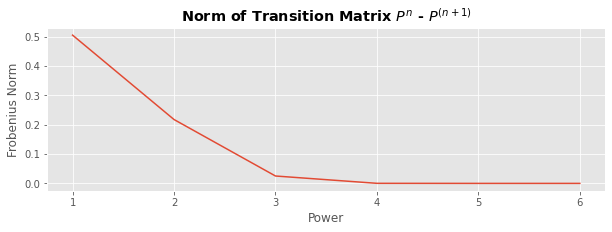

Stationary Vector: 


,Bins,Empirical Distribution,Stationary Vector,Absolute Error
State,,,,
1,"[0.0, 4.7]",0.0104,0.0104,1.3294e-06
2,"[4.7, 7.16]",0.1145,0.1145,4.4789e-06
3,"[7.16, 9.62]",0.3113,0.2790,3.2323e-02
4,"[9.62, 12.08]",0.2315,0.2638,3.2234e-02
5,"[12.08, 14.54]",0.1817,0.1727,9.0102e-03
6,"[14.54, 17.0]",0.0771,0.0862,9.0677e-03
7,"[17.0, 19.46]",0.0433,0.0433,1.7240e-05
8,"[19.46, 21.92]",0.0174,0.0174,4.8283e-06
9,"[21.92, 24.38]",0.0099,0.0097,1.3381e-04


In [20]:
'''Find Stationary Vector'''
P = df_TMatrix.values
Pnext = P.copy()
Pnorm = []
cnt = 1
maxIterations = 20 
tol = 1e-12

for i in range(0,maxIterations):
    Pnext = np.matmul(P,Pnext)
    Pnorm.append(np.linalg.norm(P - Pnext))
    cnt = cnt + 1
    if Pnorm[-1] < tol:
        break
    P = Pnext.copy()
print('Check Row Stochastic:')
print('Sum = {:e}'.format(np.sum(Pnext[0,:])))
dfBins['Stationary Vector'] = Pnext[0,:].reshape(-1,1)
dfBins['Absolute Error'] = dfBins['Stationary Vector'] - dfBins['Empirical Distribution']
dfBins['Absolute Error'] = dfBins['Absolute Error'].apply(np.abs)
plt.figure(figsize=(10,3))
plt.plot(range(1,cnt),Pnorm)
plt.xlabel('Power')
plt.ylabel('Frobenius Norm')
plt.title('Norm of Transition Matrix $P^n$ - $P^{(n+1)}$',
         fontweight='bold')
plt.show()
print('Stationary Vector: ')
dfBins.index.name = 'State'
display(dfBins)



In [21]:
print(dfBins.to_latex(index=True,bold_rows=True))

\begin{tabular}{llrrr}
\toprule
{} &            Bins &  Empirical Distribution &  Stationary Vector &  Absolute Error \\
\textbf{State} &                 &                         &                    &                 \\
\midrule
\textbf{1    } &      [0.0, 4.7] &                  0.0104 &             0.0104 &      1.3294e-06 \\
\textbf{2    } &     [4.7, 7.16] &                  0.1145 &             0.1145 &      4.4789e-06 \\
\textbf{3    } &    [7.16, 9.62] &                  0.3113 &             0.2790 &      3.2323e-02 \\
\textbf{4    } &   [9.62, 12.08] &                  0.2315 &             0.2638 &      3.2234e-02 \\
\textbf{5    } &  [12.08, 14.54] &                  0.1817 &             0.1727 &      9.0102e-03 \\
\textbf{6    } &   [14.54, 17.0] &                  0.0771 &             0.0862 &      9.0677e-03 \\
\textbf{7    } &   [17.0, 19.46] &                  0.0433 &             0.0433 &      1.7240e-05 \\
\textbf{8    } &  [19.46, 21.92] &                  0.0174 &  

## Step 8: Compare Empirical Distribution and Stationary Distribution
### Plot Occupation Frequency, Stationary Vector and Error Between the Two

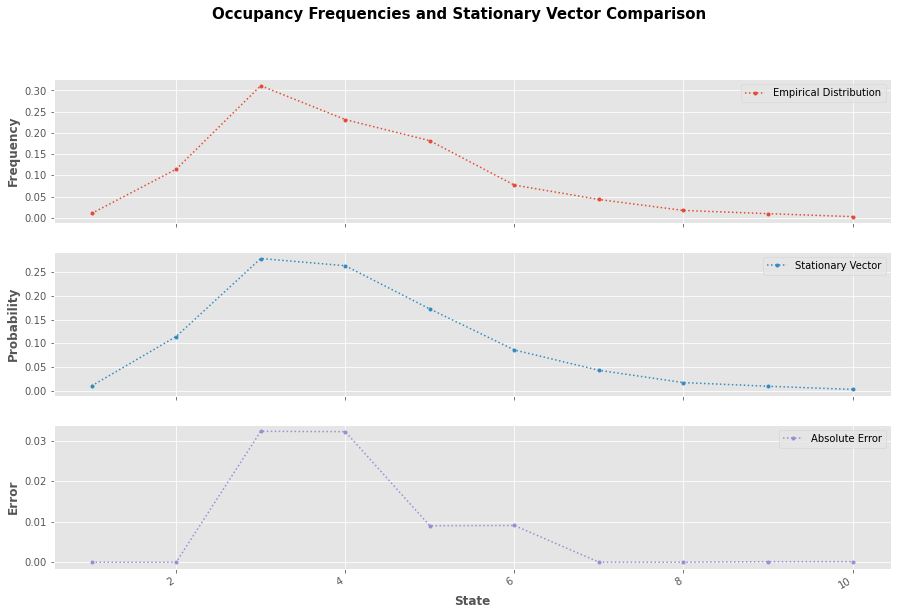

In [22]:
cols = dfBins.columns[1:]
ax = dfBins[cols].plot(subplots=True,figsize=(15,10),linestyle='dotted', marker='.')
_ = plt.suptitle('Occupancy Frequencies and Stationary Vector Comparison',
            fontweight='bold',fontsize=15)
ax = ax.ravel()
ax[-1].set_xlabel('State',fontweight='bold')
for i,lbl in enumerate(['Frequency','Probability','Error']):
    ax[i].set_ylabel(lbl,fontweight='bold')


## Step 10: Simulate Markov Chain

In [23]:
def simulate(P,n_steps,states,state0):
    states = list(states)
    
    # Build Matricies to Simulate Steps
    srt_matrix = np.zeros_like(P,dtype='int64') 
    P_cumulative = np.zeros_like(P)
    for i,row in enumerate(P):
        srt_matrix[i,:] = np.argsort(row)
        P_cumulative[i,:] = row[srt_matrix[i,:]].cumsum()
    
    # Begin Simulation
    sim = [state0]
    eps = np.finfo(1.0).resolution # smallest number representatble in this range
    for i in range(0,n_steps-1):
        rnd = np.random.rand() + eps # rand [0,1.0) so add eps to make (0,1]
        si = states.index(sim[-1]) # current state index
        x = np.array(np.where(P_cumulative[si,:] >rnd))[0]
        sip1 = srt_matrix[si,x][0] # next state index
        sim.append(states[sip1])  # add name of state to sim
    return sim
    
    

#### Simulate

In [24]:
N = len(dfStates)
s0 = dfStates['STATES'].iloc[0]
np.random.seed(42) # for repeatability
sim = simulate(df_TMatrix.values,N,list(df_TMatrix.index),s0)

In [25]:
'''Enter Simulation in Dataframe'''
dfSim = dfStates.copy()
dfSim['SIM'] = sim

dfSim.columns = ['Date','Original Data','Original States',
                'Simulation States']
dfSim.set_index('Date',inplace=True)
dfSim.head(10)

,Original Data,Original States,Simulation States
Date,,,
2000-01-01,11.41,4,4
2000-01-02,8.95,3,5
2000-01-03,12.97,5,4
2000-01-04,14.32,5,3
2000-01-05,16.11,6,4
2000-01-06,6.93,2,2
2000-01-07,13.20,5,5
2000-01-08,11.41,4,7
2000-01-09,10.96,4,5


### Compare Simulation and Original Data

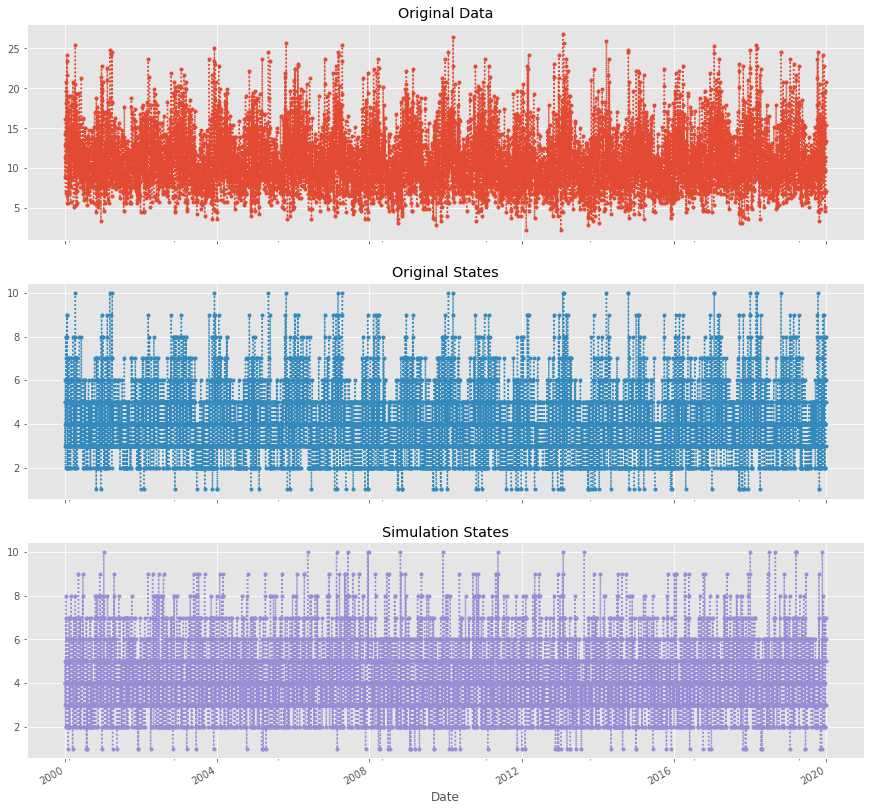

In [26]:
_ = dfSim.plot(figsize=(15,15),subplots=True,title=list(dfSim.columns),legend=False,
              linestyle='dotted', marker='.')


### Compare on Smaller Time Scale

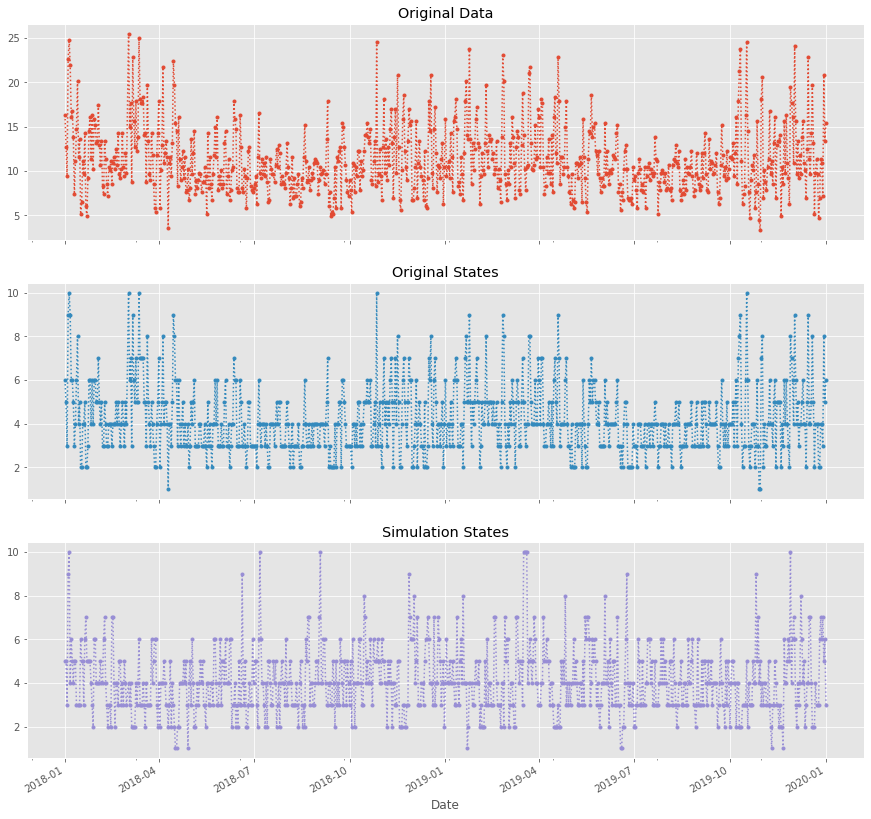

In [27]:
ts = dt.datetime(2018,1,1,0,0,0)
te = dt.datetime(2020,1,1,0,0,0)
_ = dfSim.loc[ts:te].plot(figsize=(15,15),subplots=True,title=list(dfSim.columns),legend=False,
              linestyle='dotted', marker='.')


## Step 11: Compare Simulation and Original Data by Autocorrelation

In [28]:
'''Load Autocorrelation '''
with open('acf_sim.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    acf_sim = pickle.load(f)
    
with open('acf_data.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    acf_data = pickle.load(f)

In [29]:
dfSim['Data ACF'] = acf_data
dfSim['Sim ACF'] = acf_sim

### Plot Autocorrelation Function

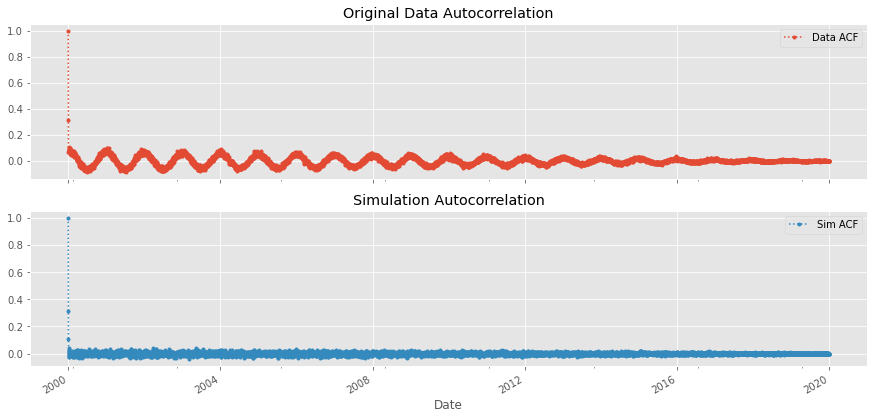

In [30]:
_ = dfSim[['Data ACF','Sim ACF']].plot(figsize=(15,7),subplots=True,
                                       title=['Original Data Autocorrelation','Simulation Autocorrelation'],
                                       legend=True, linestyle='dotted', marker='.')

## Step 12: Goodness of Fit Test

In [31]:
def getTwoStepTransitions(state, Y):
    lastIndex = len(Y)-2 
    twoStepState = []
    transStates = list(set(Y)) # get list of all states
    idxState = np.where(Y==state)[0] # get indicies where chain is in state
    
    # log all two step from i states
    for idx in idxState:
        if not(idx >= lastIndex):
            twoStepState.append(Y[idx+2])
    
    # count all the two step states
    twoStepStateCount = {}
    for ts in transStates:
        cnt = twoStepState.count(ts)
        twoStepStateCount[ts] = cnt
        
    return twoStepStateCount

def getTwoStepMatrix(Y):
    states = list(set(Y))
    df = pd.DataFrame()
    for state in states:
        df = df.append(pd.Series(getTwoStepTransitions(state,Y), name=state))
    return df
    

In [32]:
'''Count all Two Step Frquencies for Original Time Series'''
dfTwoStep = getTwoStepMatrix(dfSim['Original States'].values)

print('Original Data Two-Step Transitions Frequency')    
display(dfTwoStep)

df_Ni = dfTwoStep.sum()

print('N_i # of times in state i')
display(df_Ni)

Original Data Two-Step Transitions Frequency


,1,2,3,4,5,6,7,8,9,10
1,0.0,11.0,18.0,17.0,14.0,6.0,5.0,3.0,1.0,1.0
2,13.0,120.0,235.0,203.0,116.0,76.0,55.0,11.0,7.0,0.0
3,19.0,244.0,634.0,553.0,340.0,134.0,65.0,26.0,15.0,6.0
4,18.0,220.0,526.0,531.0,344.0,155.0,69.0,42.0,16.0,5.0
5,11.0,128.0,332.0,336.0,222.0,130.0,53.0,24.0,15.0,8.0
6,7.0,57.0,157.0,164.0,127.0,61.0,38.0,9.0,7.0,1.0
7,3.0,34.0,79.0,69.0,61.0,37.0,17.0,9.0,6.0,1.0
8,3.0,15.0,32.0,29.0,19.0,18.0,7.0,1.0,3.0,0.0
9,2.0,7.0,17.0,17.0,11.0,9.0,5.0,2.0,1.0,0.0
10,0.0,0.0,5.0,6.0,6.0,3.0,2.0,0.0,0.0,0.0


N_i # of times in state i


1       76.0
2      836.0
3     2035.0
4     1925.0
5     1260.0
6      629.0
7      316.0
8      127.0
9       71.0
10      22.0
dtype: float64

In [33]:
dfTwoStepMarkov = np.matmul(df_TMatrix.values,df_TMatrix.values)
dfTwoStepMarkov = pd.DataFrame(dfTwoStepMarkov,index=dfTwoStep.index,columns=dfTwoStep.columns)

print('Model Two Step Probabilties')
display(dfTwoStepMarkov)

Model Two Step Probabilties


,1,2,3,4,5,6,7,8,9,10
1,0.0212,0.1459,0.2808,0.2466,0.1610,0.0774,0.0436,0.0145,0.0069,0.0020
2,0.0162,0.1426,0.2958,0.2542,0.1568,0.0737,0.0371,0.0141,0.0075,0.0020
3,0.0118,0.1277,0.2943,0.2620,0.1631,0.0773,0.0372,0.0153,0.0087,0.0025
4,0.0094,0.1137,0.2848,0.2666,0.1717,0.0836,0.0407,0.0170,0.0097,0.0029
5,0.0083,0.1028,0.2724,0.2684,0.1804,0.0911,0.0455,0.0179,0.0102,0.0032
6,0.0076,0.0891,0.2499,0.2664,0.1908,0.1037,0.0549,0.0218,0.0118,0.0040
7,0.0069,0.0812,0.2337,0.2690,0.1975,0.1118,0.0615,0.0216,0.0124,0.0043
8,0.0068,0.0805,0.2275,0.2594,0.1973,0.1170,0.0651,0.0277,0.0136,0.0051
9,0.0041,0.0579,0.1783,0.2505,0.2094,0.1428,0.0892,0.0379,0.0211,0.0087
10,0.0040,0.0571,0.1810,0.2475,0.2016,0.1422,0.0896,0.0428,0.0209,0.0134


In [34]:
dfExpected = dfTwoStepMarkov.copy(deep=True)
for col in dfTwoStepMarkov.columns:
    dfExpected[col] = dfTwoStepMarkov[col]*df_Ni
print('Expected Frequencies')
dfExpected

Expected Frequencies


,1,2,3,4,5,6,7,8,9,10
1,1.6133,11.0884,21.3419,18.7400,12.2395,5.8856,3.3119,1.1031,0.5260,0.1504
2,13.5676,119.2197,247.2743,212.5220,131.0995,61.5885,31.0089,11.7617,6.2908,1.6670
3,24.0963,259.9493,598.9531,533.2640,331.9431,157.2518,75.6116,31.2182,17.6232,5.0895
4,18.0926,218.7902,548.2240,513.2673,330.5382,160.8425,78.2815,32.6769,18.6264,5.6604
5,10.4203,129.4902,343.1634,338.1953,227.2601,114.7767,57.3023,22.5105,12.8928,3.9884
6,4.7655,56.0212,157.1808,167.5864,120.0349,65.2007,34.5021,13.7370,7.4248,2.5465
7,2.1944,25.6446,73.8462,85.0064,62.4111,35.3358,19.4420,6.8413,3.9313,1.3467
8,0.8587,10.2291,28.8905,32.9401,25.0600,14.8608,8.2738,3.5163,1.7294,0.6415
9,0.2927,4.1140,12.6562,17.7833,14.8694,10.1414,6.3342,2.6942,1.5002,0.6145
10,0.0877,1.2564,3.9818,5.4444,4.4345,3.1291,1.9715,0.9413,0.4588,0.2945


## Pearson's goodness of fit Test Statistic

#### For Each State i
\begin{equation}
TS_i = \sum_{j=1}^M \frac{\text{Data Two Step Frequency}_j - \text{Predicted Two Step Frequency}_j}{\text{Predicted Two Step Frequency}_j}
\end{equation}
for $M \in \text{two step states}$

$p-value = \mathbb{P}\big( \chi^2 > TS \big) = 1 - \mathbb{P}\big( \chi^2 < TS \big) = 1 - cdf(TS)$

In [35]:
'''Compute TS'''
from scipy.stats import chisquare,chi2


test_metric = 16.919 # p value of 95% degrees of freedom = 10 -1 = 9 (10 states, 1 constraint)
degrees_of_freedom = len(dfTwoStep.columns) - 1 # 10 states and 1 constraint p11 + p12... = 1
rv = chi2(degrees_of_freedom)

TS = np.zeros((len(dfTwoStep.index),4))
result = []
for k, idx in enumerate(dfTwoStep.index):
    observed = dfTwoStep.loc[idx].values
    expected = dfExpected.loc[idx].values
    
    d = observed - expected
    TS[k,0] = np.sum(d*d/expected)
    TS[k,1] = chisquare(observed,f_exp=expected,ddof=degrees_of_freedom).statistic
    TS[k,2] = 1 - rv.cdf(TS[k,0])
    TS[k,3] = test_metric
    result.append('Reject Null' if TS[k,0] > TS[k,3]  else 'Accept Null' )
dfTest = pd.DataFrame(TS,index=dfTwoStep.index,columns=['TS','Scipy TS','P-Value','$X^2_{m-1,1-a}$'])
dfTest['Results'] = result

print('Null Hypothesis is that the Model is a Good Fit for the Data')
dfTest.index.rename('State',inplace=True)
display(dfTest)

Null Hypothesis is that the Model is a Good Fit for the Data


,TS,Scipy TS,P-Value,"$X^2_{m-1,1-a}$",Results
State,,,,,
1,11.9048,11.9048,0.2187,16.919,Accept Null
2,26.5339,26.5339,0.0017,16.919,Reject Null
3,11.3861,11.3861,0.2502,16.919,Accept Null
4,6.4891,6.4891,0.6901,16.919,Accept Null
5,7.3686,7.3686,0.5988,16.919,Accept Null
6,4.7682,4.7682,0.8540,16.919,Accept Null
7,8.6676,8.6676,0.4685,16.919,Accept Null
8,14.0716,14.0716,0.1198,16.919,Accept Null
9,15.8874,15.8874,0.0693,16.919,Accept Null


In [36]:
print(dfTest[['TS','P-Value','$X^2_{m-1,1-a}$','Results']].to_latex(index=True,bold_rows=True))

\begin{tabular}{lrrrl}
\toprule
{} &       TS &  P-Value &  \$X\textasciicircum 2\_\{m-1,1-a\}\$ &      Results \\
\textbf{State} &          &          &                  &              \\
\midrule
\textbf{1    } &  11.9048 &   0.2187 &           16.919 &  Accept Null \\
\textbf{2    } &  26.5339 &   0.0017 &           16.919 &  Reject Null \\
\textbf{3    } &  11.3861 &   0.2502 &           16.919 &  Accept Null \\
\textbf{4    } &   6.4891 &   0.6901 &           16.919 &  Accept Null \\
\textbf{5    } &   7.3686 &   0.5988 &           16.919 &  Accept Null \\
\textbf{6    } &   4.7682 &   0.8540 &           16.919 &  Accept Null \\
\textbf{7    } &   8.6676 &   0.4685 &           16.919 &  Accept Null \\
\textbf{8    } &  14.0716 &   0.1198 &           16.919 &  Accept Null \\
\textbf{9    } &  15.8874 &   0.0693 &           16.919 &  Accept Null \\
\textbf{10   } &   3.9141 &   0.9170 &           16.919 &  Accept Null \\
\bottomrule
\end{tabular}



In [37]:
'''Inspect Accepted Model States'''

good = [1,3,4,5,6,7,8,9,10]
print('Data Good States')
display(dfTwoStep.loc[good])
print('Model Good States')
display(dfExpected.loc[good].round(0))

Data Good States


,1,2,3,4,5,6,7,8,9,10
State,,,,,,,,,,
1,0.0,11.0,18.0,17.0,14.0,6.0,5.0,3.0,1.0,1.0
3,19.0,244.0,634.0,553.0,340.0,134.0,65.0,26.0,15.0,6.0
4,18.0,220.0,526.0,531.0,344.0,155.0,69.0,42.0,16.0,5.0
5,11.0,128.0,332.0,336.0,222.0,130.0,53.0,24.0,15.0,8.0
6,7.0,57.0,157.0,164.0,127.0,61.0,38.0,9.0,7.0,1.0
7,3.0,34.0,79.0,69.0,61.0,37.0,17.0,9.0,6.0,1.0
8,3.0,15.0,32.0,29.0,19.0,18.0,7.0,1.0,3.0,0.0
9,2.0,7.0,17.0,17.0,11.0,9.0,5.0,2.0,1.0,0.0
10,0.0,0.0,5.0,6.0,6.0,3.0,2.0,0.0,0.0,0.0


Model Good States


,1,2,3,4,5,6,7,8,9,10
1,2.0,11.0,21.0,19.0,12.0,6.0,3.0,1.0,1.0,0.0
3,24.0,260.0,599.0,533.0,332.0,157.0,76.0,31.0,18.0,5.0
4,18.0,219.0,548.0,513.0,331.0,161.0,78.0,33.0,19.0,6.0
5,10.0,129.0,343.0,338.0,227.0,115.0,57.0,23.0,13.0,4.0
6,5.0,56.0,157.0,168.0,120.0,65.0,35.0,14.0,7.0,3.0
7,2.0,26.0,74.0,85.0,62.0,35.0,19.0,7.0,4.0,1.0
8,1.0,10.0,29.0,33.0,25.0,15.0,8.0,4.0,2.0,1.0
9,0.0,4.0,13.0,18.0,15.0,10.0,6.0,3.0,2.0,1.0
10,0.0,1.0,4.0,5.0,4.0,3.0,2.0,1.0,0.0,0.0


In [38]:
'''Inspect Rejected Model States'''

bad= [2]
print('Data Rejected States')
display(dfTwoStep.loc[bad])
print('Model Rejected States')
display(dfExpected.loc[bad].round(0))

Data Rejected States


,1,2,3,4,5,6,7,8,9,10
State,,,,,,,,,,
2,13.0,120.0,235.0,203.0,116.0,76.0,55.0,11.0,7.0,0.0


Model Rejected States


,1,2,3,4,5,6,7,8,9,10
2,14.0,119.0,247.0,213.0,131.0,62.0,31.0,12.0,6.0,2.0


## Fit Sinousiod

In [227]:
from scipy.fft import fft

# get time index 1 day data, and values
tt = np.array(dfStates.index,dtype=float)
yy = dfStates.AWND.values
tt = np.array(tt)
yy = np.array(yy)

# subtract out DC term
ym = yy.mean()

# Number of sample points
N = tt.size
# sample spacing
T = tt[1]-tt[0]
x = np.linspace(0.0, N*T, N)
yf = fft(yy - ym)
yf = 2.0/N * np.abs(yf[0:N//2])
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

spikes = np.argsort(-yf)
ym

10.916950267159885

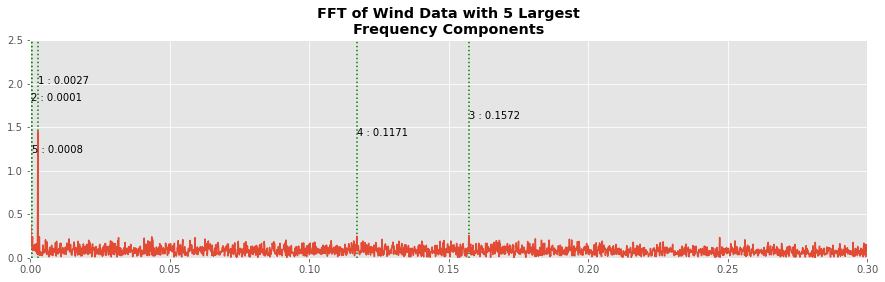

In [162]:
plt.figure(figsize=(15,4))
plt.plot(xf, yf)
topFreqs = spikes[0:5]
for i,spike in enumerate(topFreqs):
    plt.vlines(xf[spike],0,2.5,linestyles='dotted',color='g')
    plt.text(xf[spike],2-i*0.2,'{:d} : {:0.4f}'.format(i+1,xf[spike]))
plt.xlim(0,0.3)
plt.ylim(0,2.5)
_=plt.title('FFT of Wind Data with {:d} Largest\nFrequency Components'.format(topFreqs.size),
           fontweight='bold')

In [165]:
from scipy.optimize import minimize
# fit data
def multiSin(A,ytrue,t,freqs,offset):
    M = ytrue.size
    N = freqs.size
    rsme = 0
    for i in range(0,M-1):
        # loop through y terms
        s = 0
        for j in range(0,N-1):
            # calc model
            s = s + A[j]*np.sin(2*np.pi*xf[freqs[j]]*t[i] + offset)
        s = s + ym
        rsme = rsme + (ytrue[i] - s) * (ytrue[i] - s)
    rsme = np.sqrt(rsme/M)
    return rsme


A0 = np.ones_like(topFreqs)*1/topFreqs.size
args = (yy,tt,topFreqs,0.88)
res = minimize(multiSin,A0,args=args,method='CG')

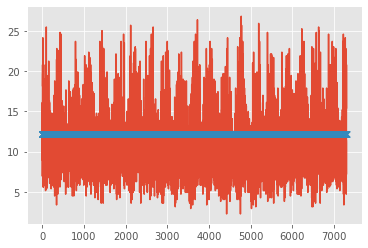

In [167]:
def yhat(t,A,freqs):
    yh = np.zeros_like(t)
    for i in range(t.size):
        for j in range(freqs.size):
            yh[i] = yh[i] + A[j]*np.sin(2*np.pi*t[i] + 0.88)
    yh = yh + ym
    return yh
yh = yhat(tt,res.x,topFreqs)
plt.plot(tt,yy)
plt.plot(tt,yh,'x')

## Build FFT Filter

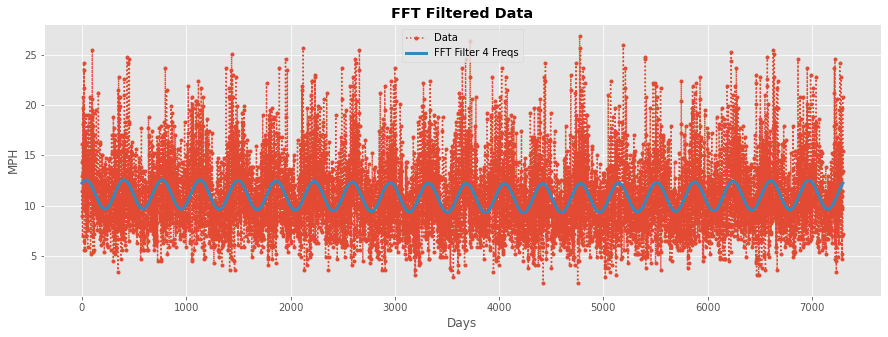

In [271]:
from scipy import fftpack
NUM_FREQS = 4


yy_fft = fftpack.fft(yy)
yy_pow = np.abs(yy_fft)
yy_freq = fftpack.fftfreq(yy.size, d=1.0) # time step on day

flt_mask = np.argsort(-yy_pow)[NUM_FREQS:] # filter out all but top 2 frequences
flt_freq_fft = yy_fft.copy()
flt_freq_fft[flt_mask] = 0
filtered_sig = np.abs(fftpack.ifft(flt_freq_fft))

plt.figure(figsize=(15,5))
plt.plot(tt,yy,':.',label='Data')
plt.plot(tt,filtered_sig,linewidth= 3, label='FFT Filter {:d} Freqs'.format(NUM_FREQS))
plt.legend(loc='best')
plt.ylabel('MPH')
plt.xlabel('Days')
_=plt.title('FFT Filtered Data',fontweight='bold')


## Fit Polynomial


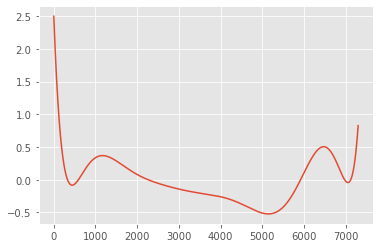

In [144]:
degree = 10
Coefs = np.polyfit(tt,yy,degree)
yp = np.polyval(Coefs,tt)
plt.plot(tt,yp)

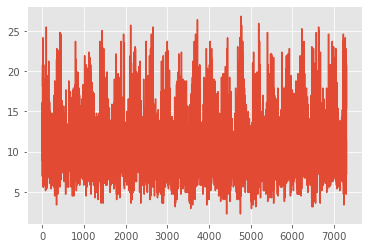

In [168]:
from scipy.interpolate import CubicSpline,PPoly
cs = CubicSpline(tt,yy)
ycs = cs(tt)
plt.plot(tt,ycs)

In [169]:
import scipy.optimize


def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f,
            "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

In [170]:
res = fit_sin(tt,yy)

In [171]:
dfSim['Sinewave'] = res['fitfunc'](tt)

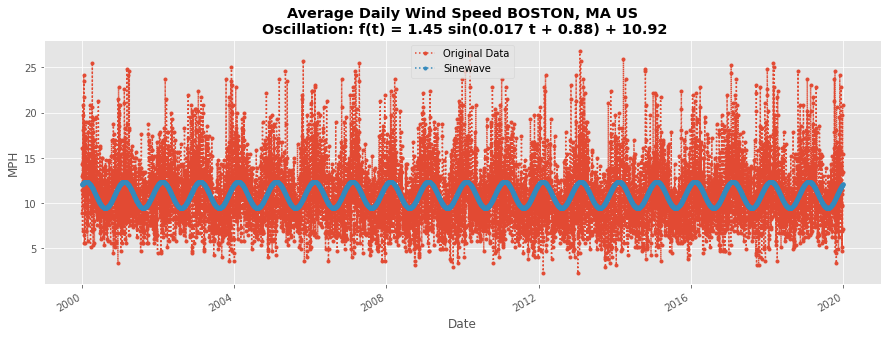

In [192]:
ts = dt.datetime(2015,1,1,0,0,0)
te = dt.datetime(2019,1,1,0,0,0)
s = 'f(t) = {:0.2f} sin({:0.3f} t + {:0.2f}) + {:0.2f}'.format(res['amp'],res['omega'],res['phase'],res['offset'])
title = 'Average Daily Wind Speed {:s}\n Oscillation: '.format(location, station) + s
dfSim[['Original Data','Sinewave']].plot(figsize=(15,5),linestyle='dotted', marker='.')
plt.title(title,fontweight='bold')
_ = plt.ylabel('MPH')

# Subtract out Sinousiod

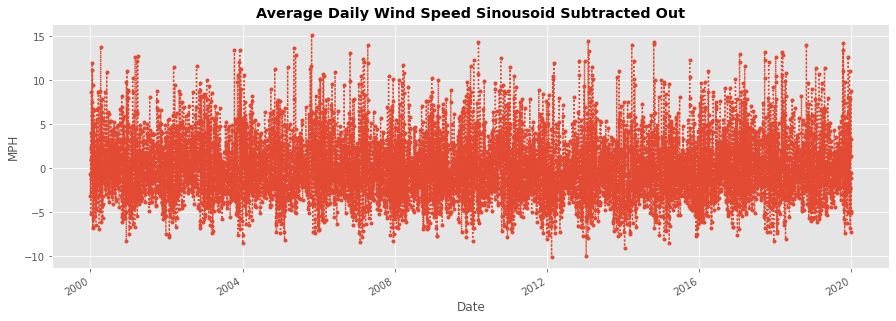

In [215]:
dfSim['Original Minus Sinewave'] = dfSim['Original Data'] - dfSim['Sinewave']

title = 'Average Daily Wind Speed Sinousoid Subtracted Out'
dfSim['Original Minus Sinewave'].plot(figsize=(15,5),linestyle='dotted', marker='.')
plt.title(title,fontweight='bold')
_ = plt.ylabel('MPH')



# Try Cubic Spline Fit

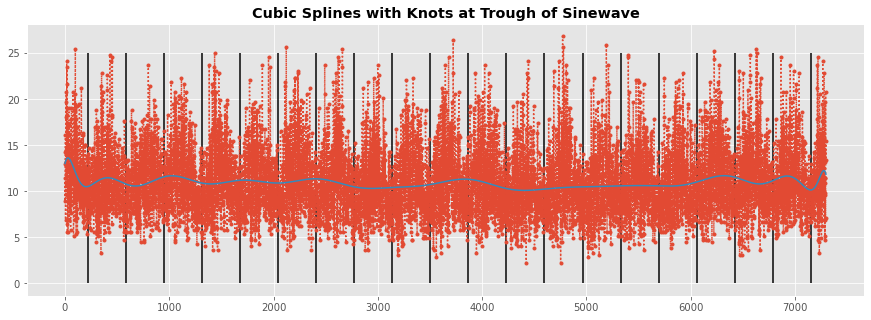

In [226]:
from scipy.interpolate import LSQUnivariateSpline
knots = tt[np.sort(np.argsort(dfSim['Sinewave'].values)[:20])]

lsq_cs = LSQUnivariateSpline(tt,yy,knots,k=5)

plt.figure(figsize=(15,5))
for k in knots:
        plt.vlines(k,0,25,color='k')
plt.plot(tt,yy,':.')
plt.plot(tt,lsq_cs(tt))

_=plt.title('Cubic Splines with Knots at Trough of Sinewave',
         fontweight='bold')